In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
stations = Base.classes.station
measurements = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#show measurements column names
measurement_first_row = session.query(measurements).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fb79ed37400>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
#Show five rows from hawaii_measurements
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
#show stations column names
station_first_row = session.query(stations).first()
station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fb79c74d2b0>,
 'id': 1,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'latitude': 21.2716,
 'longitude': -157.8168}

In [13]:
#Show five rows from hawaii_stations
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

In [15]:
#get last date
last_date = session.query(measurements.date).order_by(measurements.date.desc()).first()
print(last_date)

('2017-08-23',)


In [16]:
#last 12 months of data: date - 365
last_12= dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_12)

2016-08-23


In [17]:
#query to retrieve the last 12 months of precipitation data
last_12_months = session.query(measurements.prcp, measurements.date).\
    filter(measurements.date > last_12).order_by(measurements.date).all()

In [18]:
#create df for plotting
last_12m_df= pd.DataFrame(last_12_months)
last_12m_df.head()


,prcp,date
0,0.08,2016-08-24
1,2.15,2016-08-24
2,2.28,2016-08-24
3,NaN,2016-08-24
4,1.22,2016-08-24


In [19]:
# reset index=date
last_12m_df.set_index('date').head()


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


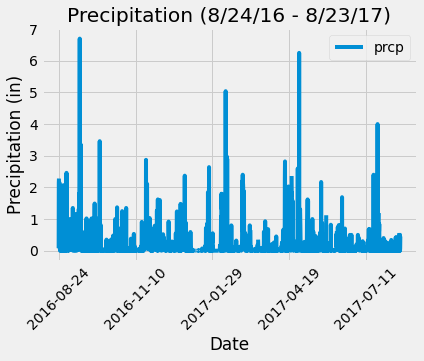

In [36]:
#plot
last_12m_df.plot("date","prcp")
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Precipitation (8/24/16 - 8/23/17)")
plt.xticks(rotation=45)
plt.show()

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12m_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(stations.station).count()
print(stations_count)

9


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(measurements.station, func.count(measurements.tobs)).group_by(measurements.station).\
                    order_by(func.count(measurements.tobs).desc()).all()
print(station_activity)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
hi_act_temp_data = session.query(func.min(measurements.tobs),func.max(measurements.tobs),func.avg(measurements.tobs)).\
                filter(measurements.station == 'USC00519281').all()
print(hi_act_temp_data)

[(54.0, 85.0, 71.66378066378067)]


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
hi_act= session.query(measurements.tobs,measurements.date,measurements.station).\
                     filter(measurements.station == 'USC00519281').\
                    filter(measurements.date >last_12).\
                        order_by(measurements.date).all()

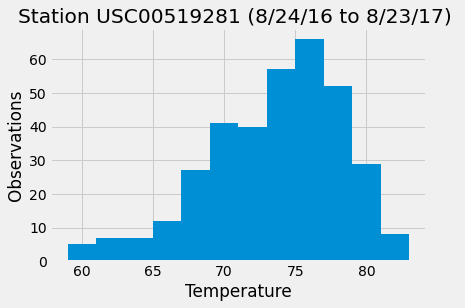

In [26]:
temp_df=pd.DataFrame(hi_act)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Observations")
plt.title("Station USC00519281 (8/24/16 to 8/23/17) ")
plt.show()

In [27]:
#convert date and prcp to a dictionary. dat as key and prcp as value
date_prcp=session.query(measurements.date,measurements.prcp).all()
date_prcp_df=pd.DataFrame(date_prcp).set_index('date')
date_prcp_dict=date_prcp_df.to_dict()
date_prcp_df.head()

,prcp
date,
2010-01-01,0.08
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-06,NaN


In [28]:
#convert stations into dictionary
stats_all=session.query(stations.station).group_by(stations.station).all()
station_df=pd.DataFrame(stats_all)
station_dict= station_df.to_dict()

In [29]:
#convert date and temp obs for most active station for last year of data to dict
hi_act_df=pd.DataFrame(hi_act).set_index('date')
hi_act_dict=hi_act_df.to_dict()
hi_act_df.head()

,tobs,station
date,,
2016-08-24,77.0,USC00519281
2016-08-25,80.0,USC00519281
2016-08-26,80.0,USC00519281
2016-08-27,75.0,USC00519281
2016-08-28,73.0,USC00519281


In [44]:
#api routes
from flask import Flask, jsonify
# Flask Setup
app = Flask(__name__)


@app.route("/")
def welcome():
  return( 
        f"Welcome to the My Trip Page API! <br/>"
        f"Available Routes:<br/>"
        f'/api/v1.0/<2015-8-10>' 
        f'/api/v1.0/<2015-8-10>/<2015-8-14>'
        f"/api/v1.0/precipitation"
        f'/api/v1.0/stations'
        f'/api/v1.0/tobs')

@app.route('/api/v1.0/precipitation')
def precip():
    """Return date and precipitation data as json"""
    return jsonify(date_prcp_dict)

@app.route('/api/v1.0/stations')
def stations():
    """Return station data as json"""
    return jsonify(station_dict)

@app.route('/api/v1.0/tobs')
def temperatures():
    """Returm Highest Active Station Tempuratures and Date as json"""
    return jsonify(hi_act_dict)

@app.route('/api/v1.0/<start_date>')
def date_start(start_date):
    """Return min,max,avg temperature for start date and all days after"""
    date_start_results=session.query(func.min(measurements.tobs), func.avg(measurements.tobs),func.max(measurements.tobs)).\
                        filter(measurements.date >= start_date).all()
    return(date_start_results)
@app.route('/api/v1.0/<start_date>/<end_date>')
def date_start_end(start_date,end_date):
        """Return min, max and avg temperature for between the start and end dates"""
        date_start_end_results=session.query(func.min(measurements.tobs), func.avg(measurements.tobs),func.max(measurements.tobs)).\
                        filter(measurements.date >= start_date).filter(measurements.date <= end_date).all()
        return(date_start_end_results)
if __name__ == "__main__":
     app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with fsevents reloader


SystemExit: 1

/Users/katherinedudzinsky/opt/anaconda3/envs/Bootcamp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Bonus Challenge Assignment

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)).\
        filter(measurements.date >= start_date).filter(measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
mytrip_start_date = dt.date(2015, 8,10)
mytrip_end_date= dt.date(2015, 8,14)
prev_year = dt.timedelta(days=365)

trip_avg_year = (calc_temps((mytrip_start_date-prev_year), (mytrip_end_date-prev_year)))
print(trip_avg_year)

[(68.0, 76.0, 82.0)]


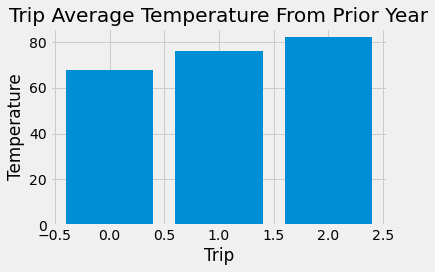

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
fig, ax = plt.subplots()
x = range(3)
ax.bar(x,[x for x in trip_avg_year[0]])
ax.set_title('Trip Average Temperature From Prior Year')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()

In [40]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
vacay_precip=session.query(measurements.date,measurements.station,measurements.prcp).\
                filter(measurements.date>=mytrip_start_date-prev_year).\
                filter(measurements.date<=mytrip_end_date-prev_year).\
                order_by(measurements.station).all()
#df fr vaca precip by station
vacay_df=pd.DataFrame(vacay_precip)
rain_per_station = pd.pivot_table(vacay_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station

,prcp
station,
USC00511918,0.01
USC00513117,0.43
USC00514830,0.11
USC00516128,0.59
USC00517948,0.02
USC00519281,0.24
USC00519397,0.06
USC00519523,0.27


In [41]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurements.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
